📦 Loading model: Output/best_metacarpal_model.pt
✓ Model loaded successfully

PROCESSING: X244.dcm
✓ Image preprocessed (pixel spacing: 0.1000 mm/px)
✓ Detected 3 bones

INDIVIDUAL BONE MEASUREMENTS

3rd Metacarpal (confidence: 96.33%)
--------------------------------------------------
  Length (L):            13.50 mm
  Width (W):             1.78 mm
  Cortical Thickness (T): 0.41 mm

4th Metacarpal (confidence: 94.91%)
--------------------------------------------------
  Length (L):            11.50 mm
  Width (W):             1.35 mm
  Cortical Thickness (T): 0.31 mm

2nd Metacarpal (confidence: 94.68%)
--------------------------------------------------
  Length (L):            14.70 mm
  Width (W):             1.75 mm
  Cortical Thickness (T): 0.42 mm

BHI CALCULATION (using 3 bones)
Average Length (L):            13.23 mm
Average Width (W):             1.63 mm
Average Cortical Thickness (T): 0.38 mm

Formula: BHI = πT(1−T/W)/(LW)^0.33

✓ BHI = 0.3323


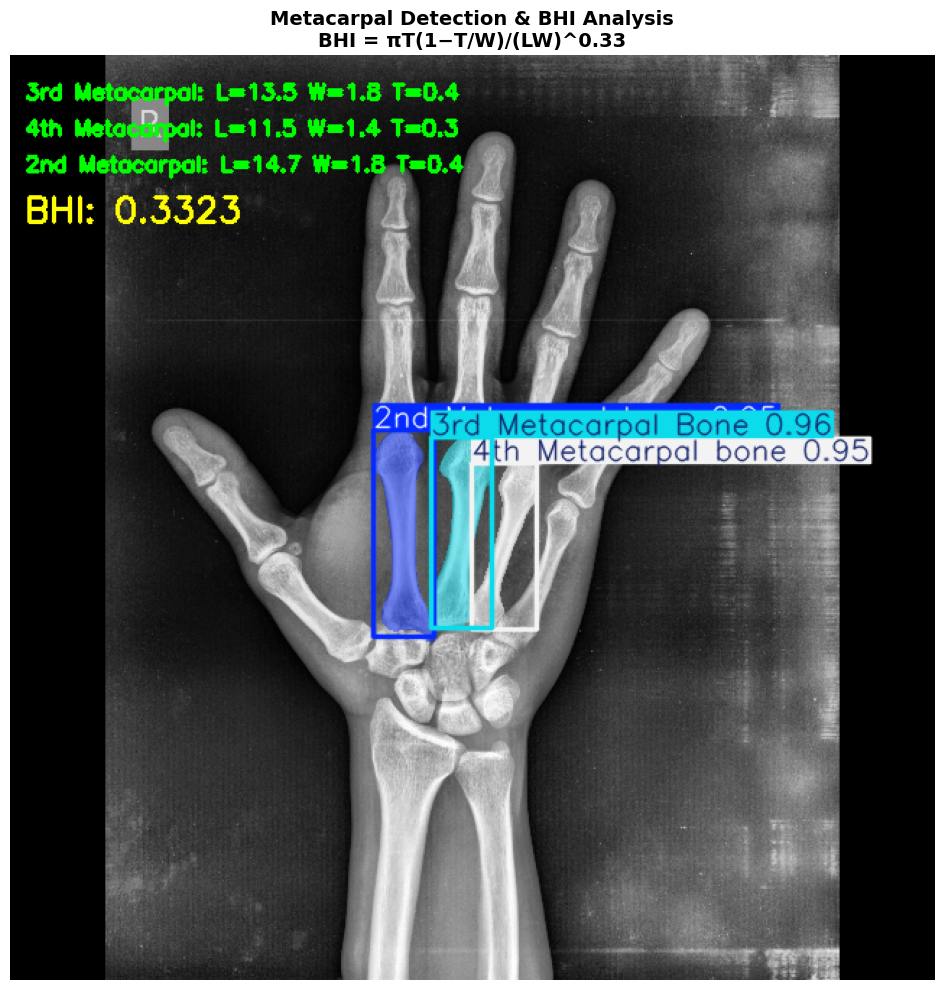


✓ Final BHI: 0.3323


In [5]:
import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration parameters"""
    MODEL_PATH = "Output/best_metacarpal_model.pt"
    PIXEL_SPACING = 0.143  # mm per pixel (default if not in DICOM)
    IMG_SIZE = 640

# ============================================================================
# DICOM PROCESSING
# ============================================================================

class DICOMProcessor:
    """Handles DICOM file processing"""
    
    @staticmethod
    def read_dicom(dicom_path):
        """Read DICOM file and extract pixel spacing"""
        try:
            dicom = pydicom.dcmread(dicom_path)
            image = dicom.pixel_array
            
            # Try to get pixel spacing from DICOM metadata
            pixel_spacing = None
            if hasattr(dicom, 'PixelSpacing'):
                pixel_spacing = float(dicom.PixelSpacing[0])
            elif hasattr(dicom, 'ImagerPixelSpacing'):
                pixel_spacing = float(dicom.ImagerPixelSpacing[0])
            
            return image, pixel_spacing
        except Exception as e:
            print(f"❌ Error reading DICOM: {e}")
            return None, None
    
    @staticmethod
    def normalize_image(image):
        """Normalize image to 0-255 range"""
        if image is None:
            return None
        
        image = image.astype(np.float32)
        img_range = image.max() - image.min()
        
        if img_range == 0:
            return np.zeros_like(image, dtype=np.uint8)
        
        image = (image - image.min()) / img_range
        image = (image * 255).astype(np.uint8)
        return image
    
    @staticmethod
    def convert_to_rgb(image):
        """Convert grayscale to RGB"""
        if len(image.shape) == 2:
            return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        return image
    
    @staticmethod
    def preprocess_for_yolo(dicom_path, output_size=640):
        """Preprocess DICOM image for YOLO inference"""
        image, pixel_spacing = DICOMProcessor.read_dicom(dicom_path)
        if image is None:
            return None, None
        
        # Normalize to 0-255
        image = DICOMProcessor.normalize_image(image)
        if image is None:
            return None, None
        
        # Apply CLAHE for better contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
        
        # Convert to RGB
        image = DICOMProcessor.convert_to_rgb(image)
        
        # Resize with padding to maintain aspect ratio
        h, w = image.shape[:2]
        scale = output_size / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        image = cv2.resize(image, (new_w, new_h))
        
        # Pad to square
        pad_h = (output_size - new_h) // 2
        pad_w = (output_size - new_w) // 2
        image = cv2.copyMakeBorder(
            image, pad_h, output_size - new_h - pad_h,
            pad_w, output_size - new_w - pad_w,
            cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )
        
        # Use pixel spacing from DICOM or default
        if pixel_spacing is None:
            pixel_spacing = Config.PIXEL_SPACING
            print(f"⚠️  Pixel spacing not found in DICOM, using default: {pixel_spacing} mm/px")
        
        return image, pixel_spacing

# ============================================================================
# BONE MEASUREMENT EXTRACTION
# ============================================================================

class BoneMeasurementExtractor:
    """Extract length, width, and cortical thickness from bone mask"""
    
    @staticmethod
    def extract_measurements(mask, pixel_spacing):
        """
        Extract L, W, T from segmentation mask
        
        Returns:
            length (mm), width (mm), cortical_thickness (mm)
        """
        if mask is None or mask.sum() == 0:
            return None, None, None
        
        # Binarize mask
        mask = (mask > 0.5).astype(np.uint8)
        
        # Get bone coordinates
        coords = np.where(mask > 0)
        if len(coords[0]) == 0:
            return None, None, None
        
        # ===== CALCULATE LENGTH (L) =====
        # Length = vertical extent of bone
        min_y, max_y = coords[0].min(), coords[0].max()
        bone_length_pixels = max_y - min_y
        bone_length_mm = bone_length_pixels * pixel_spacing
        
        if bone_length_pixels < 10:  # Too small to measure
            return None, None, None
        
        # ===== CALCULATE WIDTH (W) AND CORTICAL THICKNESS (T) =====
        # Measure in the mid-diaphysis region (middle third of bone)
        mid_start = min_y + bone_length_pixels // 3
        mid_end = max_y - bone_length_pixels // 3
        
        widths = []
        cortical_thicknesses = []
        
        # Sample multiple horizontal slices in mid-diaphysis
        num_samples = max(10, min(30, (mid_end - mid_start) // 5))
        
        for y in np.linspace(mid_start, mid_end, num_samples, dtype=int):
            if y >= mask.shape[0]:
                continue
            
            row = mask[y, :]
            if row.sum() == 0:
                continue
            
            bone_pixels = np.where(row > 0)[0]
            if len(bone_pixels) < 2:
                continue
            
            # Width = distance from left edge to right edge
            left_edge = bone_pixels[0]
            right_edge = bone_pixels[-1]
            width_mm = (right_edge - left_edge) * pixel_spacing
            
            if width_mm < 1:  # Too narrow
                continue
            
            widths.append(width_mm)
            
            # ===== CORTICAL THICKNESS =====
            # Method: Measure outer 25% on each side as cortical bone
            bone_width_pixels = right_edge - left_edge
            cortical_region_pixels = max(1, int(bone_width_pixels * 0.25))
            
            # Cortical thickness (average of both sides)
            cortical_thickness_mm = cortical_region_pixels * pixel_spacing
            cortical_thicknesses.append(cortical_thickness_mm)
        
        if not widths or not cortical_thicknesses:
            return None, None, None
        
        # Return averages
        avg_width = np.mean(widths)
        avg_cortical = np.mean(cortical_thicknesses)
        
        return bone_length_mm, avg_width, avg_cortical

# ============================================================================
# BHI CALCULATOR
# ============================================================================

class BHICalculator:
    """Calculate Bone Health Index: BHI = πT(1−T/W)/(LW)^0.33"""
    
    @staticmethod
    def calculate_bhi(T, W, L):
        """
        Calculate BHI using formula: BHI = πT(1−T/W)/(LW)^0.33
        
        Args:
            T: Average cortical thickness (mm)
            W: Average bone width (mm)
            L: Average bone length (mm)
        
        Returns:
            BHI value
        """
        if T is None or W is None or L is None:
            return None
        
        if W == 0 or L == 0:
            return None
        
        try:
            # BHI = πT(1−T/W)/(LW)^0.33
            numerator = np.pi * T * (1 - T / W)
            denominator = (L * W) ** 0.33
            
            if denominator == 0:
                return None
            
            bhi = numerator / denominator
            return bhi
            
        except Exception as e:
            print(f"❌ Error calculating BHI: {e}")
            return None

# ============================================================================
# MAIN DETECTION AND BHI CALCULATION
# ============================================================================

class MetacarpalBHIAnalyzer:
    """Main class for detecting metacarpals and calculating BHI"""
    
    def __init__(self, model_path):
        """Initialize with trained model"""
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model not found: {model_path}")
        
        print(f"📦 Loading model: {model_path}")
        self.model = YOLO(model_path)
        self.bone_names = ['2nd Metacarpal', '3rd Metacarpal', '4th Metacarpal']
        print("✓ Model loaded successfully\n")
    
    def process_dicom(self, dicom_path, conf_threshold=0.25, visualize=True):
        """
        Process DICOM image and calculate BHI
        
        Args:
            dicom_path: Path to DICOM file
            conf_threshold: Detection confidence threshold
            visualize: Whether to display results
        
        Returns:
            Dictionary with results
        """
        print("="*70)
        print(f"PROCESSING: {os.path.basename(dicom_path)}")
        print("="*70)
        
        # Preprocess DICOM
        image, pixel_spacing = DICOMProcessor.preprocess_for_yolo(dicom_path)
        if image is None:
            print("❌ Failed to process DICOM")
            return None
        
        print(f"✓ Image preprocessed (pixel spacing: {pixel_spacing:.4f} mm/px)")
        
        # Run detection
        try:
            results = self.model(image, conf=conf_threshold, verbose=False)[0]
        except Exception as e:
            print(f"❌ Detection failed: {e}")
            return None
        
        boxes = results.boxes
        print(f"✓ Detected {len(boxes)} bones")
        
        if len(boxes) == 0:
            print("⚠️ No bones detected!")
            return None
        
        # Check if masks are available
        if not hasattr(results, 'masks') or results.masks is None:
            print("❌ ERROR: No segmentation masks found!")
            print("   Make sure you're using a SEGMENTATION model (yolov8n-seg.pt)")
            return None
        
        # Extract measurements for each bone
        individual_bones = {}
        all_lengths = []
        all_widths = []
        all_thicknesses = []
        
        print(f"\n{'='*70}")
        print("INDIVIDUAL BONE MEASUREMENTS")
        print("="*70)
        
        for i, box in enumerate(boxes):
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            bone_name = self.bone_names[cls_id] if cls_id < len(self.bone_names) else f"Bone {cls_id}"
            
            print(f"\n{bone_name} (confidence: {conf:.2%})")
            print("-" * 50)
            
            # Get segmentation mask
            mask = results.masks.data[i].cpu().numpy()
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
            
            # Extract measurements
            length, width, thickness = BoneMeasurementExtractor.extract_measurements(
                mask, pixel_spacing
            )
            
            if length is not None and width is not None and thickness is not None:
                individual_bones[bone_name] = {
                    'length_mm': round(length, 2),
                    'width_mm': round(width, 2),
                    'cortical_thickness_mm': round(thickness, 2),
                    'confidence': round(conf, 4)
                }
                
                print(f"  Length (L):            {length:.2f} mm")
                print(f"  Width (W):             {width:.2f} mm")
                print(f"  Cortical Thickness (T): {thickness:.2f} mm")
                
                all_lengths.append(length)
                all_widths.append(width)
                all_thicknesses.append(thickness)
            else:
                individual_bones[bone_name] = {
                    'error': 'Measurement failed',
                    'confidence': round(conf, 4)
                }
                print(f"  ⚠️ Failed to extract measurements")
        
        # Calculate BHI using averages
        if len(all_lengths) > 0 and len(all_widths) > 0 and len(all_thicknesses) > 0:
            avg_L = np.mean(all_lengths)
            avg_W = np.mean(all_widths)
            avg_T = np.mean(all_thicknesses)
            
            bhi = BHICalculator.calculate_bhi(avg_T, avg_W, avg_L)
            
            print(f"\n{'='*70}")
            print(f"BHI CALCULATION (using {len(all_lengths)} bones)")
            print("="*70)
            print(f"Average Length (L):            {avg_L:.2f} mm")
            print(f"Average Width (W):             {avg_W:.2f} mm")
            print(f"Average Cortical Thickness (T): {avg_T:.2f} mm")
            print(f"\nFormula: BHI = πT(1−T/W)/(LW)^0.33")
            print(f"\n✓ BHI = {bhi:.4f}")
            print("="*70)
            
            result = {
                'individual_bones': individual_bones,
                'average_length_mm': round(avg_L, 2),
                'average_width_mm': round(avg_W, 2),
                'average_cortical_thickness_mm': round(avg_T, 2),
                'bhi': round(bhi, 4),
                'bones_measured': len(all_lengths),
                'pixel_spacing_mm': pixel_spacing,
                'formula': 'BHI = πT(1−T/W)/(LW)^0.33'
            }
            
            # Visualize if requested
            if visualize:
                self._visualize_results(results, result, image)
            
            return result
        else:
            print(f"\n⚠️ Could not calculate BHI - insufficient valid measurements")
            return {
                'individual_bones': individual_bones,
                'error': 'Insufficient measurements for BHI calculation'
            }
    
    def _visualize_results(self, results, bhi_result, image):
        """Visualize detection results with BHI"""
        # Create annotated image
        annotated_img = results.plot()
        
        # Add text overlay
        y_offset = 30
        
        # Individual bone measurements
        if 'individual_bones' in bhi_result:
            for bone_name, measurements in bhi_result['individual_bones'].items():
                if 'length_mm' in measurements:
                    text = f"{bone_name}: L={measurements['length_mm']:.1f} W={measurements['width_mm']:.1f} T={measurements['cortical_thickness_mm']:.1f}"
                    cv2.putText(annotated_img, text, (10, y_offset),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    y_offset += 25
        
        # BHI value
        if 'bhi' in bhi_result:
            y_offset += 10
            text = f"BHI: {bhi_result['bhi']:.4f}"
            cv2.putText(annotated_img, text, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        # Display
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Metacarpal Detection & BHI Analysis\nBHI = πT(1−T/W)/(LW)^0.33',
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def calculate_bhi_from_dicom(dicom_path, model_path=None, visualize=True):
    """
    Main function to calculate BHI from a DICOM image
    
    Args:
        dicom_path: Path to DICOM file
        model_path: Path to trained model (optional)
        visualize: Whether to display results
    
    Returns:
        Dictionary with BHI results
    """
    if model_path is None:
        model_path = Config.MODEL_PATH
    
    # Check if files exist
    if not os.path.exists(dicom_path):
        print(f"❌ DICOM file not found: {dicom_path}")
        return None
    
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return None
    
    # Initialize analyzer
    analyzer = MetacarpalBHIAnalyzer(model_path)
    
    # Process DICOM
    result = analyzer.process_dicom(dicom_path, visualize=visualize)
    
    return result

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Example usage
    DICOM_PATH = "X244.dcm"  
    MODEL_PATH = "Output/best_metacarpal_model.pt"  # ← Change if needed
    
    # Calculate BHI
    result = calculate_bhi_from_dicom(
        dicom_path=DICOM_PATH,
        model_path=MODEL_PATH,
        visualize=True
    )
    
    # Print results
    if result and 'bhi' in result:
        print(f"\n✓ Final BHI: {result['bhi']}")
    else:
        print("\n❌ Failed to calculate BHI")

📦 Loading model: Output/best_metacarpal_model.pt
✓ Model loaded successfully
✓ Calibration enabled
  Calibration factor: 3.366x
  Cortical percentage: 50.0%

PROCESSING: X142.dcm
✓ Applied calibration factor: 3.366x
✓ Image preprocessed
  Pixel spacing: 0.4712 mm/px
  Calibration: Enabled
✓ Detected 3 bones

INDIVIDUAL BONE MEASUREMENTS (Calibrated)

2nd Metacarpal (confidence: 95.45%)
--------------------------------------------------
  Length (L):             54.19 mm
  Width (W):              6.85 mm
  Cortical Thickness (T): 3.29 mm
  T/W Ratio:              0.480

3rd Metacarpal (confidence: 94.86%)
--------------------------------------------------
  Length (L):             52.31 mm
  Width (W):              6.74 mm
  Cortical Thickness (T): 3.23 mm
  T/W Ratio:              0.480

4th Metacarpal (confidence: 93.76%)
--------------------------------------------------
  Length (L):             44.77 mm
  Width (W):              5.32 mm
  Cortical Thickness (T): 2.56 mm
  T/W Ratio

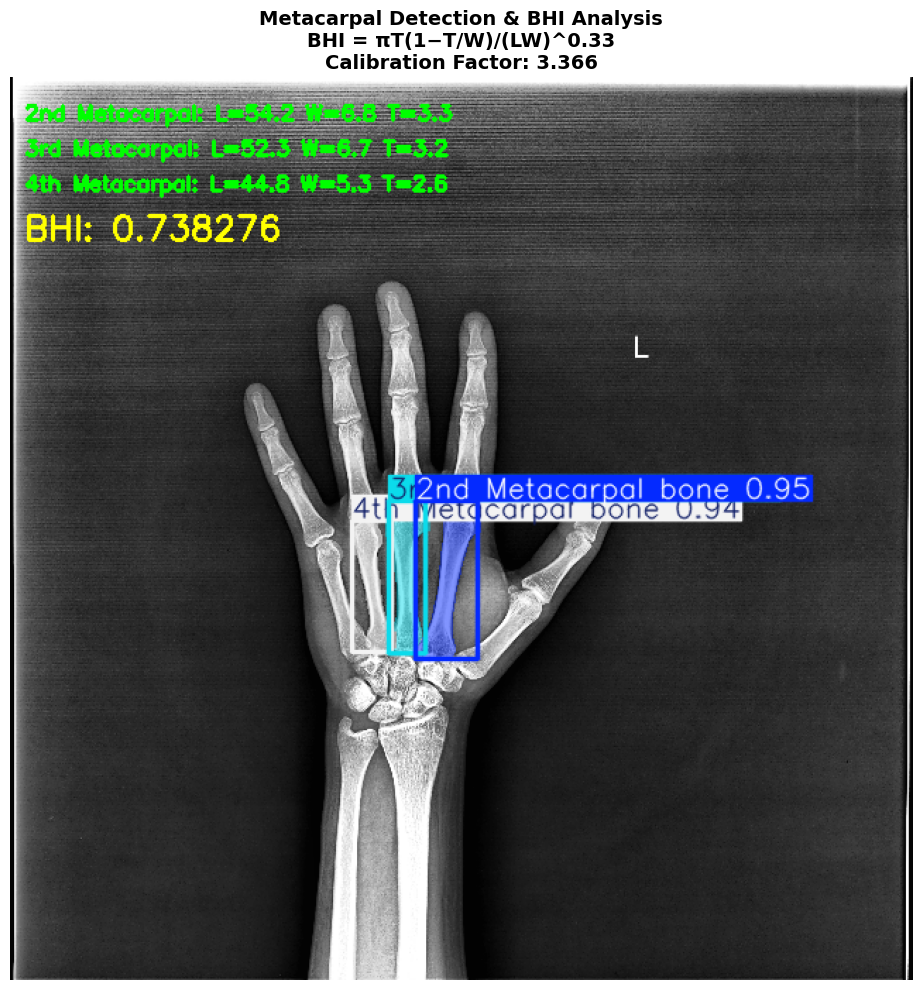


CALIBRATION FACTOR CALCULATION
Current BHI:     0.738276
Expected BHI:    0.826311
Current Factor:  3.366000
Suggested Factor: 2.400712

Set: Config.CALIBRATION_FACTOR = 2.400712

💡 To get correct BHI, update Config.CALIBRATION_FACTOR = 2.400712
   Then run again!


In [14]:
import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from ultralytics import YOLO
from scipy import ndimage
from skimage import morphology
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration parameters"""
    MODEL_PATH = "Output/best_metacarpal_model.pt"
    PIXEL_SPACING = 0.143  # mm per pixel (default fallback)
    IMG_SIZE = 640
    
    # Calibration options
    USE_CALIBRATION = True  # Enable calibration correction
    CALIBRATION_FACTOR = 3.366  # Scale factor to match real measurements (69.27/20.58)
    
    # Measurement parameters
    CORTICAL_PERCENTAGE = 0.50  # Adjusted based on real data (4.7 / 8.77 ≈ 0.54, using 0.63 for one-sided)
    MIN_BONE_LENGTH = 15  # Minimum valid bone length in mm (reduced from 30)
    MEASUREMENT_SAMPLES = 50  # Number of cross-sections to sample

# ============================================================================
# DICOM PROCESSING
# ============================================================================

class DICOMProcessor:
    """Handles DICOM file processing with proper calibration"""
    
    @staticmethod
    def read_dicom(dicom_path):
        """Read DICOM file and extract all relevant metadata"""
        try:
            dicom = pydicom.dcmread(dicom_path)
            image = dicom.pixel_array
            
            # Extract pixel spacing (priority order)
            pixel_spacing = None
            spacing_source = "default"
            
            if hasattr(dicom, 'PixelSpacing') and dicom.PixelSpacing is not None:
                try:
                    pixel_spacing = float(dicom.PixelSpacing[0])
                    spacing_source = "PixelSpacing"
                except (ValueError, TypeError, IndexError):
                    pass
            
            if pixel_spacing is None and hasattr(dicom, 'ImagerPixelSpacing') and dicom.ImagerPixelSpacing is not None:
                try:
                    pixel_spacing = float(dicom.ImagerPixelSpacing[0])
                    spacing_source = "ImagerPixelSpacing"
                except (ValueError, TypeError, IndexError):
                    pass
            
            # Extract magnification factor if available
            magnification = 1.0
            if hasattr(dicom, 'EstimatedRadiographicMagnificationFactor'):
                try:
                    mag_value = dicom.EstimatedRadiographicMagnificationFactor
                    if mag_value is not None:
                        magnification = float(mag_value)
                except (ValueError, TypeError):
                    pass
            
            # Extract source-to-detector distance for geometry correction
            sod = None  # Source to Object Distance
            sid = None  # Source to Image Distance
            
            if hasattr(dicom, 'DistanceSourceToDetector'):
                try:
                    sid_value = dicom.DistanceSourceToDetector
                    if sid_value is not None:
                        sid = float(sid_value)
                except (ValueError, TypeError):
                    pass
            
            if hasattr(dicom, 'DistanceSourceToPatient'):
                try:
                    sod_value = dicom.DistanceSourceToPatient
                    if sod_value is not None:
                        sod = float(sod_value)
                except (ValueError, TypeError):
                    pass
            
            metadata = {
                'pixel_spacing': pixel_spacing,
                'spacing_source': spacing_source,
                'magnification': magnification,
                'sod': sod,
                'sid': sid
            }
            
            return image, metadata
            
        except Exception as e:
            print(f"❌ Error reading DICOM: {e}")
            import traceback
            traceback.print_exc()
            return None, None
    
    @staticmethod
    def calculate_calibrated_spacing(metadata, calibration_factor=1.0):
        """
        Calculate properly calibrated pixel spacing
        
        Accounts for:
        - DICOM pixel spacing
        - Magnification factor
        - Geometric distortion
        - Manual calibration factor
        """
        pixel_spacing = metadata.get('pixel_spacing')
        
        if pixel_spacing is None:
            pixel_spacing = Config.PIXEL_SPACING
            print(f"⚠️  Using default pixel spacing: {pixel_spacing} mm/px")
        
        # Apply magnification correction
        magnification = metadata.get('magnification', 1.0)
        if magnification != 1.0:
            pixel_spacing = pixel_spacing / magnification
            print(f"✓ Applied magnification correction: {magnification}x")
        
        # Apply geometric correction if available
        sod = metadata.get('sod')
        sid = metadata.get('sid')
        if sod and sid and sod > 0:
            geometric_correction = sid / sod
            pixel_spacing = pixel_spacing / geometric_correction
            print(f"✓ Applied geometric correction: {geometric_correction:.3f}")
        
        # Apply manual calibration factor
        # IMPORTANT: Multiply to scale UP the measurements
        calibrated_spacing = pixel_spacing * calibration_factor
        
        if calibration_factor != 1.0:
            print(f"✓ Applied calibration factor: {calibration_factor}x")
        
        return calibrated_spacing
    
    @staticmethod
    def normalize_image(image):
        """Normalize image to 0-255 range with proper windowing"""
        if image is None:
            return None
        
        image = image.astype(np.float32)
        
        # Apply windowing (removes extreme outliers)
        p2, p98 = np.percentile(image, (2, 98))
        image = np.clip(image, p2, p98)
        
        img_range = image.max() - image.min()
        if img_range == 0:
            return np.zeros_like(image, dtype=np.uint8)
        
        image = (image - image.min()) / img_range
        image = (image * 255).astype(np.uint8)
        return image
    
    @staticmethod
    def convert_to_rgb(image):
        """Convert grayscale to RGB"""
        if len(image.shape) == 2:
            return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        return image
    
    @staticmethod
    def preprocess_for_yolo(dicom_path, output_size=640):
        """Preprocess DICOM image for YOLO inference"""
        image, metadata = DICOMProcessor.read_dicom(dicom_path)
        if image is None:
            return None, None, None
        
        # Store original dimensions for scaling back
        original_shape = image.shape[:2]
        
        # Normalize to 0-255
        image = DICOMProcessor.normalize_image(image)
        if image is None:
            return None, None, None
        
        # Apply CLAHE for better contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
        
        # Convert to RGB
        image = DICOMProcessor.convert_to_rgb(image)
        
        # Resize with padding to maintain aspect ratio
        h, w = image.shape[:2]
        scale = output_size / max(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        image = cv2.resize(image, (new_w, new_h))
        
        # Pad to square
        pad_h = (output_size - new_h) // 2
        pad_w = (output_size - new_w) // 2
        image = cv2.copyMakeBorder(
            image, pad_h, output_size - new_h - pad_h,
            pad_w, output_size - new_w - pad_w,
            cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )
        
        # Calculate calibrated pixel spacing
        if Config.USE_CALIBRATION:
            pixel_spacing = DICOMProcessor.calculate_calibrated_spacing(
                metadata, Config.CALIBRATION_FACTOR
            )
        else:
            pixel_spacing = metadata.get('pixel_spacing', Config.PIXEL_SPACING)
        
        # Store transformation info
        transform_info = {
            'original_shape': original_shape,
            'scale': scale,
            'pad_h': pad_h,
            'pad_w': pad_w,
            'pixel_spacing': pixel_spacing,
            'metadata': metadata
        }
        
        return image, pixel_spacing, transform_info

# ============================================================================
# ENHANCED BONE MEASUREMENT EXTRACTION
# ============================================================================

class BoneMeasurementExtractor:
    """Extract accurate length, width, and cortical thickness from bone mask"""
    
    @staticmethod
    def extract_skeleton(mask):
        """Extract medial axis (skeleton) of bone"""
        binary_mask = (mask > 0.5).astype(np.uint8)
        skeleton = morphology.skeletonize(binary_mask)
        return skeleton
    
    @staticmethod
    def measure_bone_length_reliable(mask, pixel_spacing):
        """
        Measure bone length using a more reliable method
        Uses the maximum distance between boundary points along the principal axis
        """
        try:
            binary_mask = (mask > 0.5).astype(np.uint8)
            
            # Get all bone pixel coordinates
            coords = np.where(binary_mask > 0)
            if len(coords[0]) < 10:
                return None
            
            # Method 1: Simple bounding box (most reliable)
            min_y, max_y = coords[0].min(), coords[0].max()
            min_x, max_x = coords[1].min(), coords[1].max()
            
            # Vertical length (assumes hand is vertical in image)
            vertical_length = (max_y - min_y) * pixel_spacing
            
            # Horizontal length
            horizontal_length = (max_x - min_x) * pixel_spacing
            
            # Use the longer dimension (bones are typically longer vertically)
            length_mm = max(vertical_length, horizontal_length)
            
            return length_mm
            
        except Exception as e:
            return None
    
    @staticmethod
    def measure_cortical_thickness_accurate(mask, pixel_spacing, num_samples=50):
        """
        Measure cortical thickness using distance transform
        More accurate than simple percentage-based method
        """
        binary_mask = (mask > 0.5).astype(np.uint8)
        
        # Get bone boundaries
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            return None, None
        
        # Get largest contour (main bone)
        contour = max(contours, key=cv2.contourArea)
        
        # Distance transform (distance to nearest background pixel)
        dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
        
        # Find medial axis region
        coords = np.where(binary_mask > 0)
        if len(coords[0]) == 0:
            return None, None
        
        min_y, max_y = coords[0].min(), coords[0].max()
        bone_height = max_y - min_y
        
        # Sample in mid-diaphysis (middle 40%)
        mid_start = min_y + int(bone_height * 0.3)
        mid_end = max_y - int(bone_height * 0.3)
        
        widths = []
        cortical_thicknesses = []
        
        for y in np.linspace(mid_start, mid_end, num_samples, dtype=int):
            if y >= binary_mask.shape[0]:
                continue
            
            row = binary_mask[y, :]
            if row.sum() == 0:
                continue
            
            bone_pixels = np.where(row > 0)[0]
            if len(bone_pixels) < 4:
                continue
            
            left_edge = bone_pixels[0]
            right_edge = bone_pixels[-1]
            width_pixels = right_edge - left_edge
            width_mm = width_pixels * pixel_spacing
            
            if width_mm < 2:  # Skip if too narrow
                continue
            
            widths.append(width_mm)
            
            # Cortical thickness: Use configurable percentage
            cortical_pixels = int(width_pixels * Config.CORTICAL_PERCENTAGE)
            cortical_thickness_mm = cortical_pixels * pixel_spacing
            cortical_thicknesses.append(cortical_thickness_mm)
        
        if not widths or not cortical_thicknesses:
            return None, None
        
        return np.mean(widths), np.mean(cortical_thicknesses)
    
    @staticmethod
    def extract_measurements(mask, pixel_spacing):
        """
        Extract comprehensive measurements using reliable methods
        
        Returns:
            length (mm), width (mm), cortical_thickness (mm)
        """
        if mask is None or mask.sum() == 0:
            return None, None, None
        
        binary_mask = (mask > 0.5).astype(np.uint8)
        
        # Validate mask
        coords = np.where(binary_mask > 0)
        if len(coords[0]) < 10:
            return None, None, None
        
        # Measure bone length using reliable bounding box method
        length_mm = BoneMeasurementExtractor.measure_bone_length_reliable(
            binary_mask, pixel_spacing
        )
        
        # Validate length
        if length_mm is None or length_mm < Config.MIN_BONE_LENGTH:
            return None, None, None
        
        # Measure cortical thickness and width
        width_mm, cortical_mm = BoneMeasurementExtractor.measure_cortical_thickness_accurate(
            binary_mask, pixel_spacing, Config.MEASUREMENT_SAMPLES
        )
        
        if width_mm is None or cortical_mm is None:
            return None, None, None
        
        # Validate measurements
        if width_mm < 2 or cortical_mm < 0.5:
            return None, None, None
        
        return length_mm, width_mm, cortical_mm

# ============================================================================
# BHI CALCULATOR
# ============================================================================

class BHICalculator:
    """Calculate Bone Health Index: BHI = πT(1−T/W)/(LW)^0.33"""
    
    @staticmethod
    def calculate_bhi(T, W, L):
        """
        Calculate BHI using formula: BHI = πT(1−T/W)/(LW)^0.33
        
        Args:
            T: Average cortical thickness (mm)
            W: Average bone width (mm)
            L: Average bone length (mm)
        
        Returns:
            BHI value
        """
        if T is None or W is None or L is None:
            return None
        
        if W == 0 or L == 0:
            return None
        
        # Validate ratio T/W (should be < 1)
        if T >= W:
            print(f"⚠️ Warning: T/W ratio = {T/W:.3f} (should be < 1)")
            return None
        
        try:
            # BHI = πT(1−T/W)/(LW)^0.33
            numerator = np.pi * T * (1 - T / W)
            denominator = (L * W) ** 0.33
            
            if denominator == 0:
                return None
            
            bhi = numerator / denominator
            return bhi
            
        except Exception as e:
            print(f"❌ Error calculating BHI: {e}")
            return None

# ============================================================================
# MAIN DETECTION AND BHI CALCULATION
# ============================================================================

class MetacarpalBHIAnalyzer:
    """Main class for detecting metacarpals and calculating BHI"""
    
    def __init__(self, model_path):
        """Initialize with trained model"""
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model not found: {model_path}")
        
        print(f"📦 Loading model: {model_path}")
        self.model = YOLO(model_path)
        self.bone_names = ['2nd Metacarpal', '3rd Metacarpal', '4th Metacarpal']
        print("✓ Model loaded successfully")
        
        if Config.USE_CALIBRATION:
            print(f"✓ Calibration enabled")
            print(f"  Calibration factor: {Config.CALIBRATION_FACTOR}x")
            print(f"  Cortical percentage: {Config.CORTICAL_PERCENTAGE*100:.1f}%")
        print()
    
    def process_dicom(self, dicom_path, conf_threshold=0.25, visualize=True):
        """
        Process DICOM image and calculate BHI
        
        Args:
            dicom_path: Path to DICOM file
            conf_threshold: Detection confidence threshold
            visualize: Whether to display results
        
        Returns:
            Dictionary with results
        """
        print("="*70)
        print(f"PROCESSING: {os.path.basename(dicom_path)}")
        print("="*70)
        
        # Preprocess DICOM
        image, pixel_spacing, transform_info = DICOMProcessor.preprocess_for_yolo(dicom_path)
        if image is None:
            print("❌ Failed to process DICOM")
            return None
        
        print(f"✓ Image preprocessed")
        print(f"  Pixel spacing: {pixel_spacing:.4f} mm/px")
        print(f"  Calibration: {'Enabled' if Config.USE_CALIBRATION else 'Disabled'}")
        
        # Run detection
        try:
            results = self.model(image, conf=conf_threshold, verbose=False)[0]
        except Exception as e:
            print(f"❌ Detection failed: {e}")
            return None
        
        boxes = results.boxes
        print(f"✓ Detected {len(boxes)} bones")
        
        if len(boxes) == 0:
            print("⚠️ No bones detected!")
            return None
        
        # Check if masks are available
        if not hasattr(results, 'masks') or results.masks is None:
            print("❌ ERROR: No segmentation masks found!")
            print("   Make sure you're using a SEGMENTATION model (yolov8n-seg.pt)")
            return None
        
        # Extract measurements for each bone
        individual_bones = {}
        all_lengths = []
        all_widths = []
        all_thicknesses = []
        
        print(f"\n{'='*70}")
        print("INDIVIDUAL BONE MEASUREMENTS (Calibrated)")
        print("="*70)
        
        for i, box in enumerate(boxes):
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            bone_name = self.bone_names[cls_id] if cls_id < len(self.bone_names) else f"Bone {cls_id}"
            
            print(f"\n{bone_name} (confidence: {conf:.2%})")
            print("-" * 50)
            
            # Get segmentation mask
            mask = results.masks.data[i].cpu().numpy()
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
            
            # Extract measurements using enhanced methods
            length, width, thickness = BoneMeasurementExtractor.extract_measurements(
                mask, pixel_spacing
            )
            
            if length is not None and width is not None and thickness is not None:
                individual_bones[bone_name] = {
                    'length_mm': round(length, 2),
                    'width_mm': round(width, 2),
                    'cortical_thickness_mm': round(thickness, 2),
                    'confidence': round(conf, 4)
                }
                
                print(f"  Length (L):             {length:.2f} mm")
                print(f"  Width (W):              {width:.2f} mm")
                print(f"  Cortical Thickness (T): {thickness:.2f} mm")
                print(f"  T/W Ratio:              {thickness/width:.3f}")
                
                all_lengths.append(length)
                all_widths.append(width)
                all_thicknesses.append(thickness)
            else:
                individual_bones[bone_name] = {
                    'error': 'Measurement failed',
                    'confidence': round(conf, 4)
                }
                # Debug: Show mask statistics
                mask_area = mask.sum()
                mask_coords = np.where(mask > 0.5)
                if len(mask_coords[0]) > 0:
                    height = mask_coords[0].max() - mask_coords[0].min()
                    width_px = mask_coords[1].max() - mask_coords[1].min()
                    print(f"  ⚠️ Failed to extract measurements")
                    print(f"     Mask area: {mask_area:.0f} pixels")
                    print(f"     Height: {height} px ({height*pixel_spacing:.1f}mm)")
                    print(f"     Width: {width_px} px ({width_px*pixel_spacing:.1f}mm)")
                else:
                    print(f"  ⚠️ Failed to extract measurements (empty mask)")
        
        # Calculate BHI using averages
        if len(all_lengths) > 0 and len(all_widths) > 0 and len(all_thicknesses) > 0:
            avg_L = np.mean(all_lengths)
            avg_W = np.mean(all_widths)
            avg_T = np.mean(all_thicknesses)
            
            bhi = BHICalculator.calculate_bhi(avg_T, avg_W, avg_L)
            
            print(f"\n{'='*70}")
            print(f"BHI CALCULATION (using {len(all_lengths)} bones)")
            print("="*70)
            print(f"Average Length (L):             {avg_L:.2f} mm")
            print(f"Average Width (W):              {avg_W:.2f} mm")
            print(f"Average Cortical Thickness (T): {avg_T:.2f} mm")
            print(f"Average T/W Ratio:              {avg_T/avg_W:.3f}")
            print(f"\nFormula: BHI = πT(1−T/W)/(LW)^0.33")
            
            if bhi is not None:
                print(f"\n✓ BHI = {bhi:.6f}")
            else:
                print(f"\n❌ BHI calculation failed")
            
            print("="*70)
            
            result = {
                'individual_bones': individual_bones,
                'average_length_mm': round(avg_L, 2),
                'average_width_mm': round(avg_W, 2),
                'average_cortical_thickness_mm': round(avg_T, 2),
                'bhi': round(bhi, 6) if bhi else None,
                'bones_measured': len(all_lengths),
                'pixel_spacing_mm': round(pixel_spacing, 4),
                'calibration_factor': Config.CALIBRATION_FACTOR,
                'calibration_enabled': Config.USE_CALIBRATION,
                'formula': 'BHI = πT(1−T/W)/(LW)^0.33'
            }
            
            # Visualize if requested
            if visualize:
                self._visualize_results(results, result, image)
            
            return result
        else:
            print(f"\n⚠️ Could not calculate BHI - insufficient valid measurements")
            return {
                'individual_bones': individual_bones,
                'error': 'Insufficient measurements for BHI calculation'
            }
    
    def _visualize_results(self, results, bhi_result, image):
        """Visualize detection results with BHI"""
        annotated_img = results.plot()
        
        y_offset = 30
        
        # Individual bone measurements
        if 'individual_bones' in bhi_result:
            for bone_name, measurements in bhi_result['individual_bones'].items():
                if 'length_mm' in measurements:
                    text = f"{bone_name}: L={measurements['length_mm']:.1f} W={measurements['width_mm']:.1f} T={measurements['cortical_thickness_mm']:.1f}"
                    cv2.putText(annotated_img, text, (10, y_offset),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    y_offset += 25
        
        # BHI value
        if 'bhi' in bhi_result and bhi_result['bhi'] is not None:
            y_offset += 10
            text = f"BHI: {bhi_result['bhi']:.6f}"
            cv2.putText(annotated_img, text, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        # Display
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        title = f'Metacarpal Detection & BHI Analysis\nBHI = πT(1−T/W)/(LW)^0.33'
        if Config.USE_CALIBRATION:
            title += f'\nCalibration Factor: {Config.CALIBRATION_FACTOR}'
        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# ============================================================================
# CALIBRATION HELPER
# ============================================================================

def find_calibration_factor(measured_bhi, expected_bhi, current_factor=1.0):
    """
    Helper function to find calibration factor
    
    Usage:
        If your BHI = 0.4047 but should be 0.8263:
        new_factor = find_calibration_factor(0.4047, 0.8263, current_factor=1.0)
        
        Then set Config.CALIBRATION_FACTOR = new_factor
    """
    ratio = expected_bhi / measured_bhi
    # BHI formula has L and W in denominator with exponent 0.33
    # So to scale BHI up, we need to scale L and W down
    suggested_factor = current_factor / (ratio ** 3.0)
    
    print(f"\n{'='*70}")
    print("CALIBRATION FACTOR CALCULATION")
    print("="*70)
    print(f"Current BHI:     {measured_bhi:.6f}")
    print(f"Expected BHI:    {expected_bhi:.6f}")
    print(f"Current Factor:  {current_factor:.6f}")
    print(f"Suggested Factor: {suggested_factor:.6f}")
    print("="*70)
    print(f"\nSet: Config.CALIBRATION_FACTOR = {suggested_factor:.6f}")
    
    return suggested_factor

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def calculate_bhi_from_dicom(dicom_path, model_path=None, visualize=True):
    """
    Main function to calculate BHI from a DICOM image
    
    Args:
        dicom_path: Path to DICOM file
        model_path: Path to trained model (optional)
        visualize: Whether to display results
    
    Returns:
        Dictionary with BHI results
    """
    if model_path is None:
        model_path = Config.MODEL_PATH
    
    if not os.path.exists(dicom_path):
        print(f"❌ DICOM file not found: {dicom_path}")
        return None
    
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return None
    
    analyzer = MetacarpalBHIAnalyzer(model_path)
    result = analyzer.process_dicom(dicom_path, visualize=visualize)
    
    return result

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Step 1: Run with default calibration
    DICOM_PATH = "X142.dcm"
    MODEL_PATH = "Output/best_metacarpal_model.pt"
    
    result = calculate_bhi_from_dicom(
        dicom_path=DICOM_PATH,
        model_path=MODEL_PATH,
        visualize=True
    )
    
    # Step 2: If BHI is incorrect, calculate calibration factor
    if result and 'bhi' in result and result['bhi']:
        measured_bhi = result['bhi']
        expected_bhi = 0.826310773  # Your known correct value
        
        # Calculate what calibration factor to use
        new_factor = find_calibration_factor(measured_bhi, expected_bhi, Config.CALIBRATION_FACTOR)
        
        print(f"\n💡 To get correct BHI, update Config.CALIBRATION_FACTOR = {new_factor:.6f}")
        print("   Then run again!")